<a href="https://colab.research.google.com/github/payaldas30/Impulse-NITK/blob/main/ExtractingFrequencyDomainfeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pywt
from scipy.signal import spectrogram

train_data_path = '/content/drive/MyDrive/Impulse/EEG_Data/train_data'


class_folders = {
    "Complex_Partial_Seizures": 0,
    "Electrographic_Seizures": 1,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 2,
    "Normal": 3
}

data_points = {}

for class_name in class_folders.keys():
    class_folder = os.path.join(train_data_path, class_name)
    for file in os.listdir(class_folder):
        if file.endswith('.npy'):
            data = np.load(os.path.join(class_folder, file))
            data_points[class_name] = data  # Store the first .npy file for the class
            break


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.5 MB/s eta 0:00:00


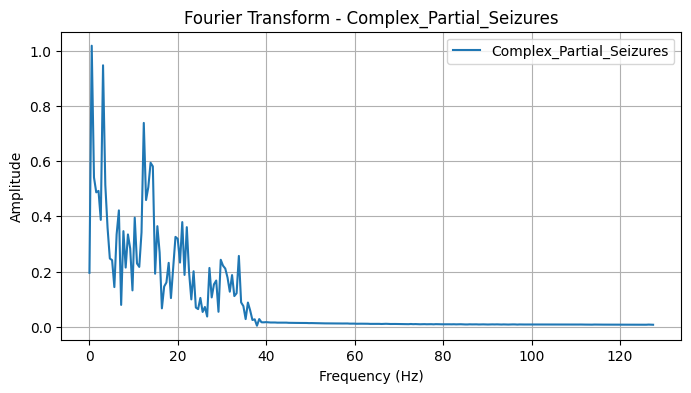

Class: Complex_Partial_Seizures | Peak Frequency: 0.51 Hz | Mean Amplitude: 0.08


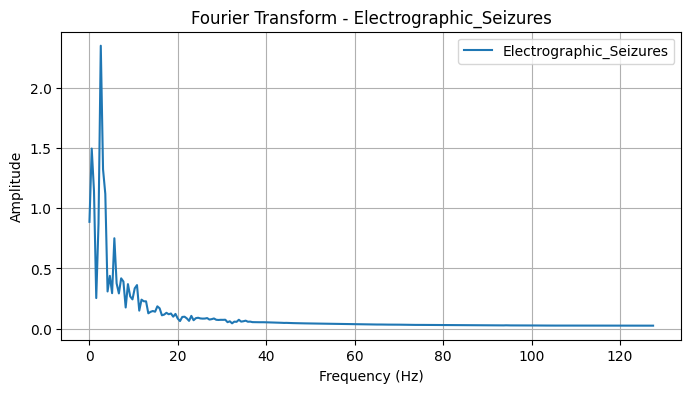

Class: Electrographic_Seizures | Peak Frequency: 2.56 Hz | Mean Amplitude: 0.10


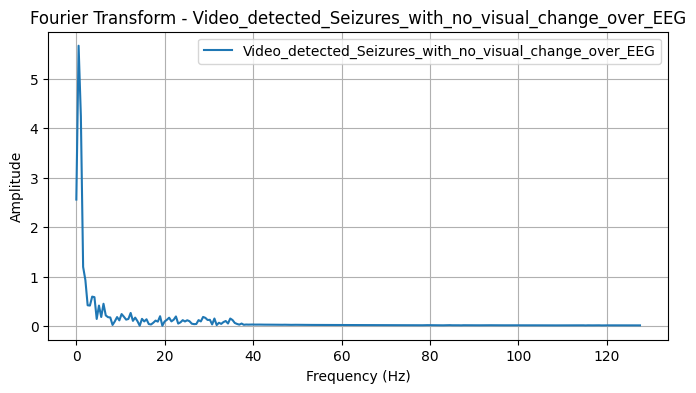

Class: Video_detected_Seizures_with_no_visual_change_over_EEG | Peak Frequency: 0.51 Hz | Mean Amplitude: 0.11


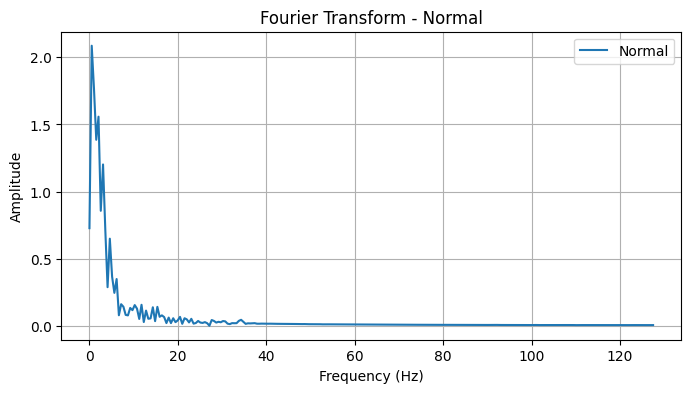

Class: Normal | Peak Frequency: 0.51 Hz | Mean Amplitude: 0.07


In [3]:
def compute_fft(signal, sampling_rate=256):
    n = len(signal)
    freq = fftfreq(n, 1 / sampling_rate)[:n // 2]
    fft_values = np.abs(fft(signal))[:n // 2]
    peak_freq = freq[np.argmax(fft_values)]
    mean_amplitude = np.mean(fft_values)
    return freq, fft_values, peak_freq, mean_amplitude

for class_name, data in data_points.items():
    signal = data[0, :]
    freq, fft_values, peak_freq, mean_amp = compute_fft(signal)

    plt.figure(figsize=(8, 4))
    plt.plot(freq, fft_values, label=f'{class_name}')
    plt.title(f"Fourier Transform - {class_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()
    plt.show()

    print(f"Class: {class_name} | Peak Frequency: {peak_freq:.2f} Hz | Mean Amplitude: {mean_amp:.2f}")

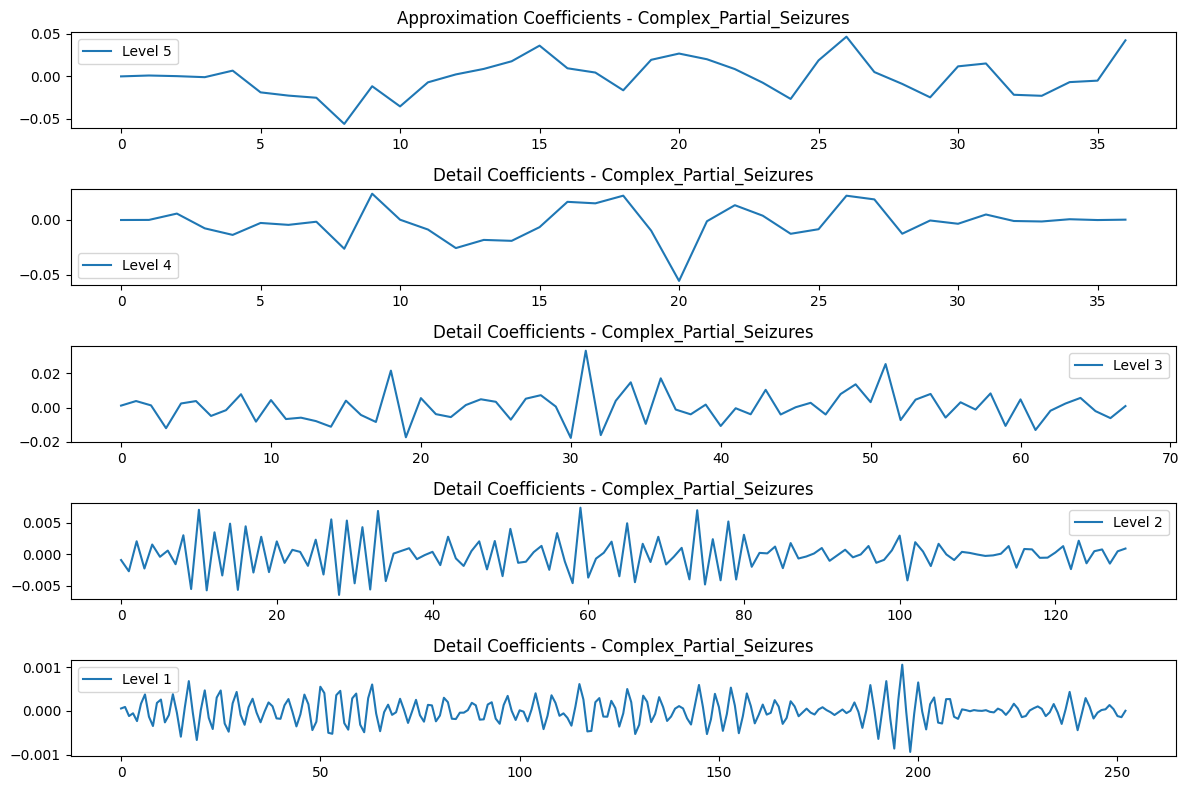

Class: Complex_Partial_Seizures
Reconstruction Errors (by level): [0.12449073562300048, 0.08296721515349441, 0.03238688636294969, 0.004432574430018355, 6.011453641980179e-17]
Most Similar Coefficient Level: 5


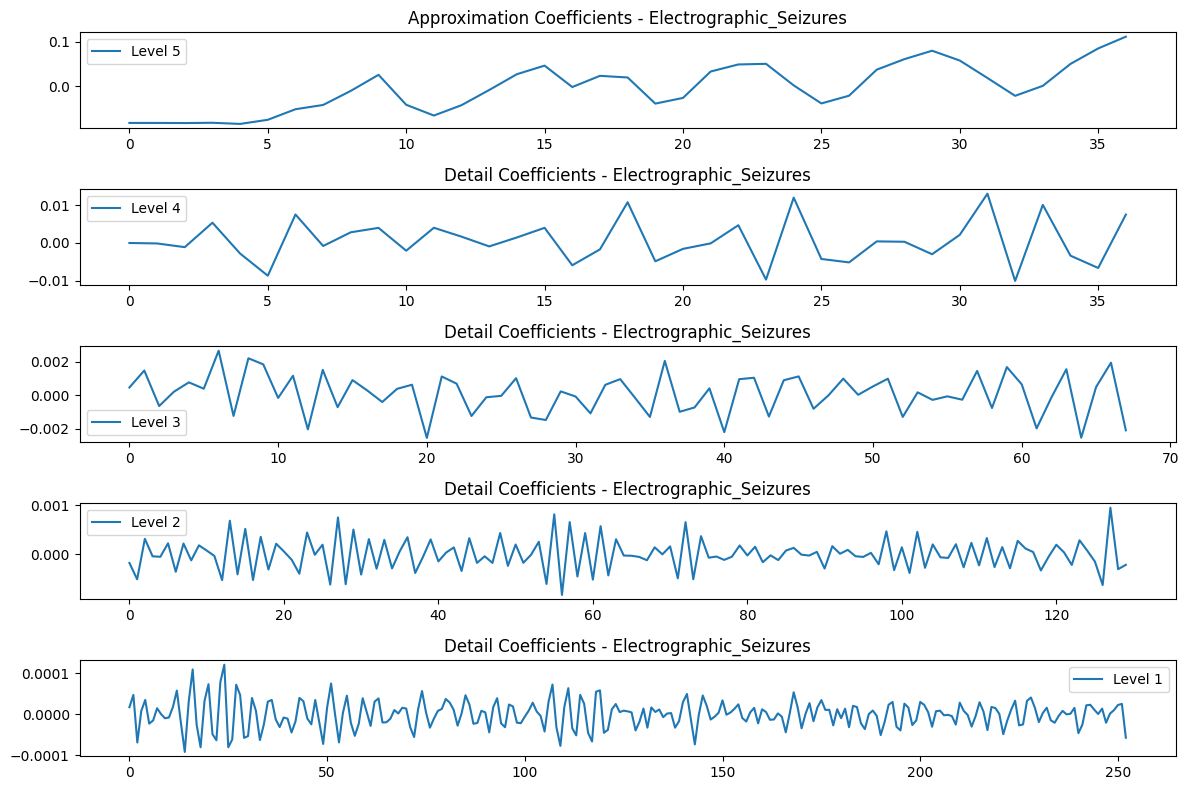

Class: Electrographic_Seizures
Reconstruction Errors (by level): [0.034684151382767384, 0.009862963583621577, 0.0036096337965128697, 0.0005247153155865658, 9.317280710020749e-17]
Most Similar Coefficient Level: 5


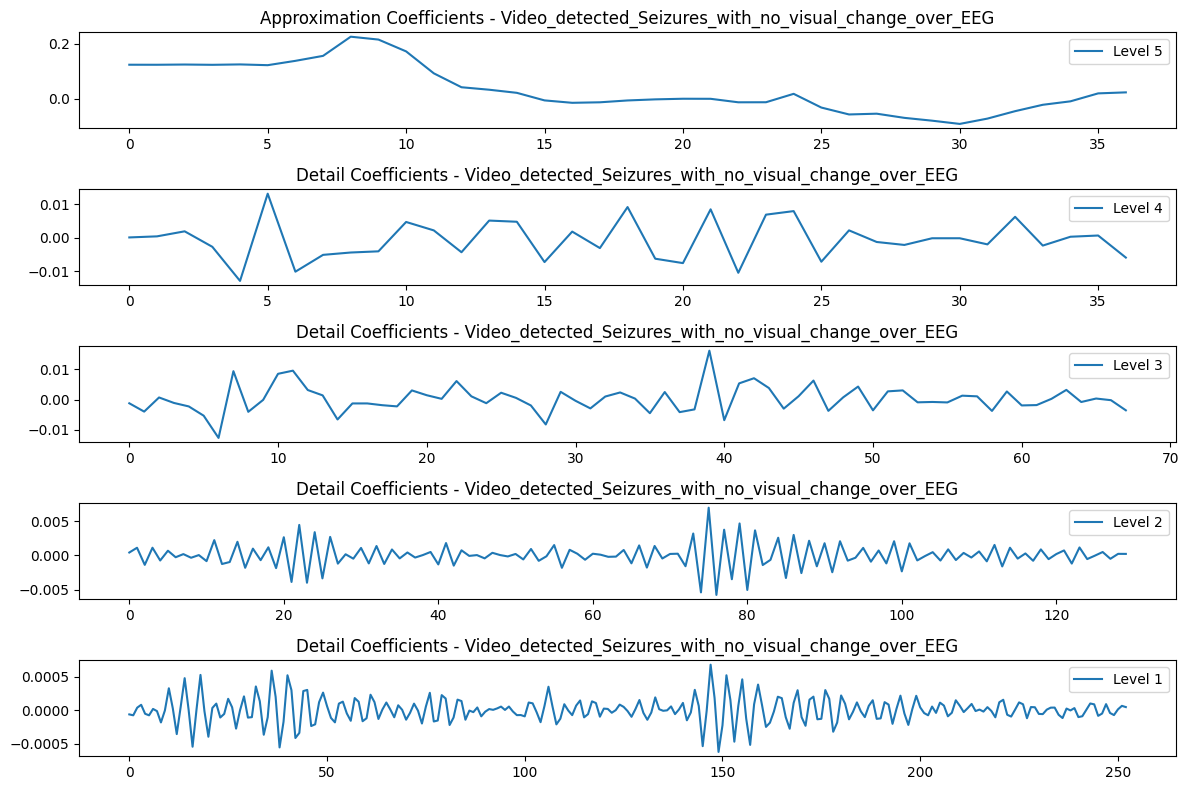

Class: Video_detected_Seizures_with_no_visual_change_over_EEG
Reconstruction Errors (by level): [0.05491387359890253, 0.041918628314242055, 0.02139509659487178, 0.002929641393749211, 1.710816727893068e-16]
Most Similar Coefficient Level: 5


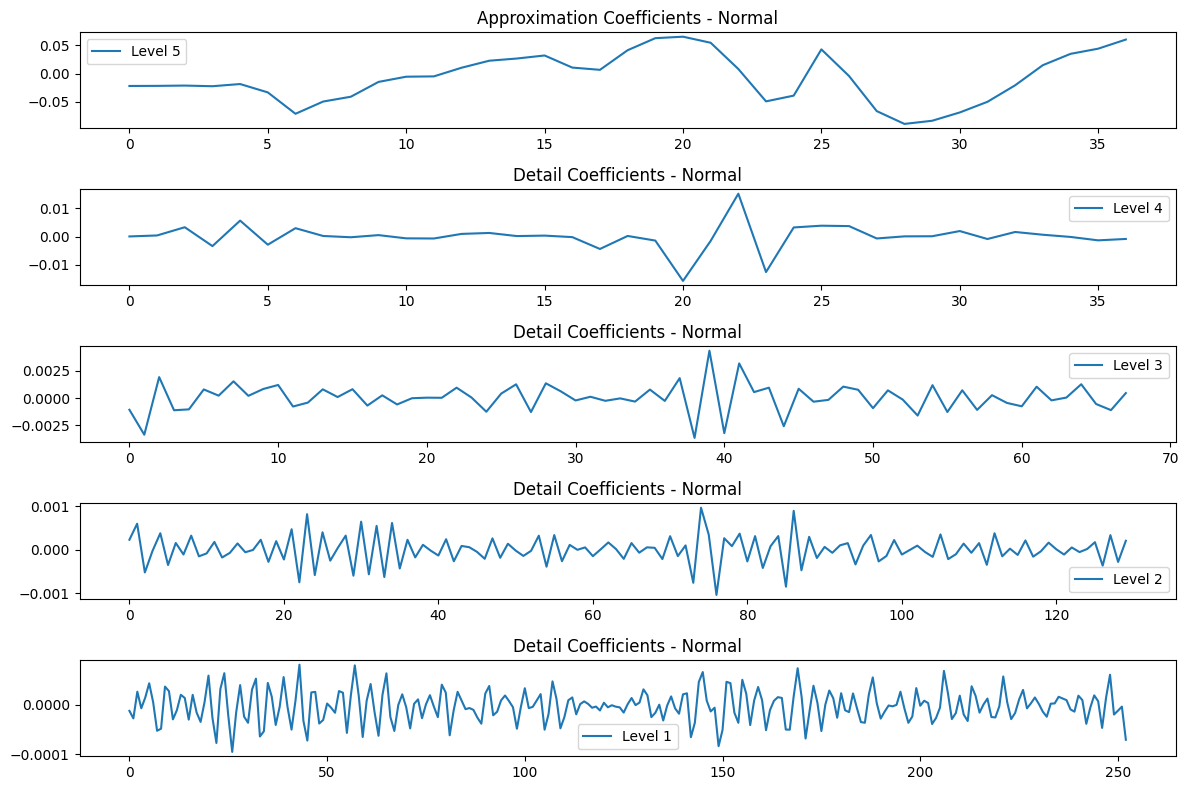

Class: Normal
Reconstruction Errors (by level): [0.029953900707523535, 0.010650131618875942, 0.0036866768334652255, 0.0005016882127189143, 8.552709119161727e-17]
Most Similar Coefficient Level: 5


In [4]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def wavelet_decomposition(signal, wavelet='db4', levels=4):
    coeffs = pywt.wavedec(signal, wavelet, level=levels)
    return coeffs

def reconstruct_and_compare(signal, coeffs, wavelet='db4'):
    original_length = len(signal)
    reconstruction_errors = []
    for i in range(len(coeffs)):
        reconstructed_signal = pywt.waverec(coeffs[:i+1] + [None]*(len(coeffs)-i-1), wavelet)
        reconstructed_signal = reconstructed_signal[:original_length]
        error = np.linalg.norm(signal - reconstructed_signal)
        reconstruction_errors.append(error)

    most_similar_level = np.argmin(reconstruction_errors) + 1
    return reconstruction_errors, most_similar_level
for class_name, data in data_points.items():
    signal = data[0,:]
    coeffs = wavelet_decomposition(signal, wavelet='db4', levels=4)

    plt.figure(figsize=(12, 8))
    for i, coeff in enumerate(coeffs):
        plt.subplot(len(coeffs), 1, i + 1)
        plt.plot(coeff, label=f"Level {len(coeffs)-i}")
        plt.title(f"{'Approximation' if i == 0 else 'Detail'} Coefficients - {class_name}")
        plt.legend()
    plt.tight_layout()
    plt.show()

    reconstruction_errors, most_similar_level = reconstruct_and_compare(signal, coeffs, wavelet='db4')

    print(f"Class: {class_name}")
    print(f"Reconstruction Errors (by level): {reconstruction_errors}")
    print(f"Most Similar Coefficient Level: {most_similar_level}")

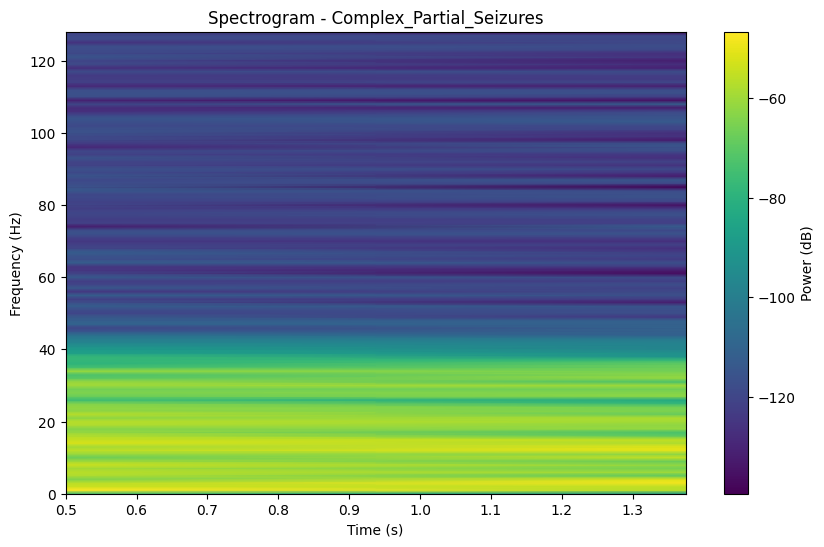

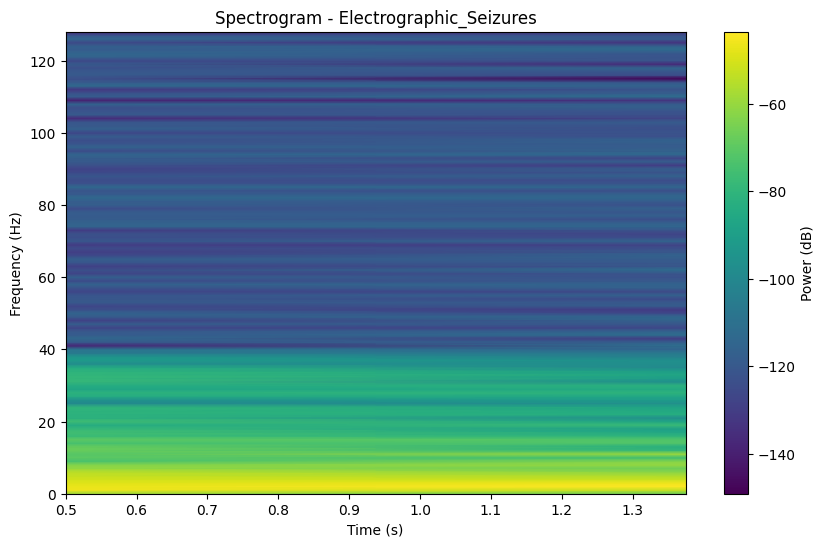

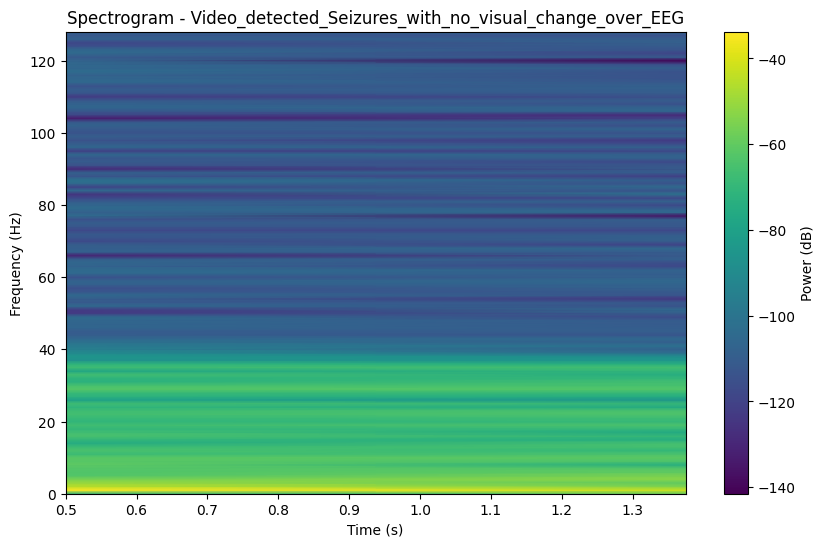

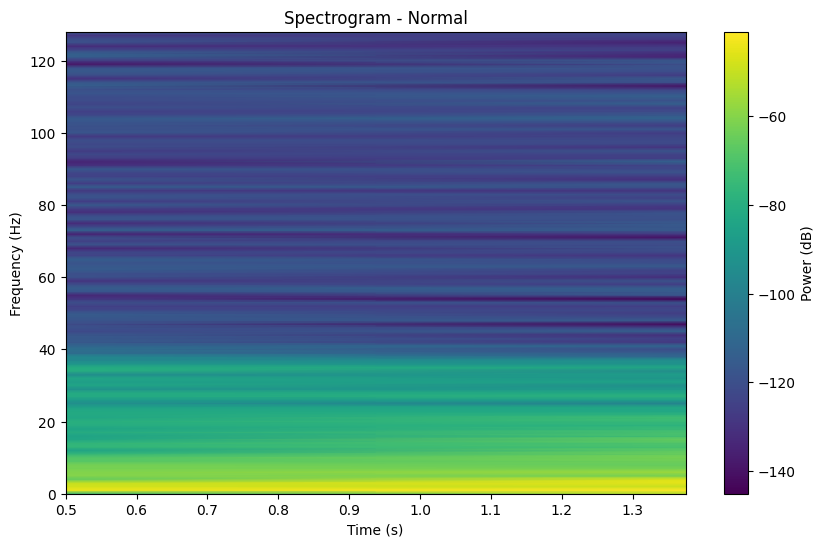

In [5]:
def generate_spectrogram(signal, sampling_rate=256):
    f, t, Sxx = spectrogram(signal, fs=sampling_rate)
    return f, t, Sxx

for class_name, data in data_points.items():
    signal = data[0, :]
    f, t, Sxx = generate_spectrogram(signal)

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title(f"Spectrogram - {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power (dB)")
    plt.show()